In [ ]:
import numpy as np
import pandas as pd
import torch
import cv2

In [ ]:
!unzip /content/drive/MyDrive/mask_detect.zip

Archive:  /content/drive/MyDrive/mask_detect.zip
  inflating: annotations/maksssksksss0.xml  
  inflating: annotations/maksssksksss1.xml  
  inflating: annotations/maksssksksss10.xml  
  inflating: annotations/maksssksksss100.xml  
  inflating: annotations/maksssksksss101.xml  
  inflating: annotations/maksssksksss102.xml  
  inflating: annotations/maksssksksss103.xml  
  inflating: annotations/maksssksksss104.xml  
  inflating: annotations/maksssksksss105.xml  
  inflating: annotations/maksssksksss106.xml  
  inflating: annotations/maksssksksss107.xml  
  inflating: annotations/maksssksksss108.xml  
  inflating: annotations/maksssksksss109.xml  
  inflating: annotations/maksssksksss11.xml  
  inflating: annotations/maksssksksss110.xml  
  inflating: annotations/maksssksksss111.xml  
  inflating: annotations/maksssksksss112.xml  
  inflating: annotations/maksssksksss113.xml  
  inflating: annotations/maksssksksss114.xml  
  inflating: annotations/maksssksksss115.xml  
  inflating: anno

In [ ]:
BATCH_SIZE = 4
RESIZE_SIZE = 400

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

CLASSES = ['background', 'without_mask', 'with_mask', 'mask_weared_incorrect']
NUM_CLASSES = 4

IMG_DIR = '/content/images'
LABEL_DIR = '/content/annotations'

In [ ]:
DEVICE

device(type='cpu')

In [ ]:
import os
import random

def train_valid_test_split(img_dir, train_split=0.15, test_split=0.15):
    files = os.listdir(img_dir)

    all_img = files

    random.shuffle(all_img)

    len_imgs = len(all_img)

    train_test_split = int((1-train_split)*len_imgs)

    train_val_df = all_img[:train_test_split]
    test_df = all_img[train_test_split:]

    len_df = len(train_val_df)

    train_val_split = int((1-test_split)*len_df)

    train_df = train_val_df[:train_val_split]
    valid_df = train_val_df[train_val_split:]

    return train_df, valid_df, test_df

train_set, valid_set, test_set = train_valid_test_split(img_dir = IMG_DIR)


In [ ]:
len(test_set)

128

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        A.RandomRotate90(0.5),
        A.MotionBlur(p=0.2),
        A.MedianBlur(blur_limit=5, p=0.2),
        A.Blur(blur_limit=5, p=0.2),
        ToTensorV2(p=1.0),
    ], bbox_params={
        'format': 'pascal_voc',
        'label_fields': ['labels']
    })

In [ ]:
class LossCounter:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
import glob
from torch.utils.data import DataLoader, Dataset, ConcatDataset
import xml.etree.ElementTree as et


class MaskDataset(Dataset):
    def __init__(self, dataset, width, height, classes, img_dir_path, xml_dir_path, transforms=None):
        self.transforms = transforms
        self.img_dir_path = img_dir_path
        self.xml_dir_path = xml_dir_path
        self.height = height
        self.width = width
        self.classes = classes
        self.dataset = dataset

    def __getitem__(self, idx):
        image_name = self.dataset[idx]
        image_path = os.path.join(self.img_dir_path, image_name)

        image = cv2.imread(image_path)

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image_resized = cv2.resize(image, (self.width, self.height))
        image_resized /= 255.0

        label_filename = image_name[:-4] + '.xml'
        label_filepath = os.path.join(self.xml_dir_path, label_filename)

        boxes, labels = [], []

        tree = et.parse(label_filepath)
        root = tree.getroot()

        for i in root.findall('size'):
            image_width = int(i.find('width').text)
            image_height = int(i.find('height').text)

        for member in root.findall('object'):
            labels.append(self.classes.index(member.find('name').text))

            xmin_temp = int(member.find('bndbox').find('xmin').text)
            xmax_temp = int(member.find('bndbox').find('xmax').text)
            ymin_temp = int(member.find('bndbox').find('ymin').text)
            ymax_temp = int(member.find('bndbox').find('ymax').text)

            x_min = (xmin_temp / image_width) * self.width
            x_max = (xmax_temp / image_width) * self.width
            y_min = (ymin_temp / image_height) * self.height
            y_max = (ymax_temp / image_height) * self.height

            if x_min > self.width:
                x_min = self.width

            if y_min > self.height:
                y_min = self.height

            if x_max > self.width:
                x_max = self.width

            if y_max > self.height:
                y_max = self.height

            boxes.append([x_min, y_min, x_max, y_max])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        if boxes.shape[0] > 1:
            iscrowd = torch.ones((boxes.shape[0],), dtype=torch.int64)
        else:
            iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)

        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['area'] = area
        target['iscrowd'] = iscrowd
        image_id = torch.tensor([idx])
        target['image_id'] = image_id

        if self.transforms:
            sample = self.transforms(image=image_resized,
                                     bboxes=target['boxes'],
                                     labels=labels)
            image_resized = sample['image']

            target['boxes'] = torch.Tensor(sample['bboxes'])

            return image_resized, target

        else:
            image_resized = np.transpose(image_resized, (2, 0, 1))
            image_resized = torch.from_numpy(image_resized)

            return image_resized, target

    def __len__(self):
        return len(self.dataset)

In [ ]:
train_dataset = MaskDataset(train_set, RESIZE_SIZE, RESIZE_SIZE, CLASSES, IMG_DIR, LABEL_DIR)
trans_train_dataset = MaskDataset(train_set, RESIZE_SIZE, RESIZE_SIZE, CLASSES, IMG_DIR, LABEL_DIR, get_train_transform())
valid_dataset = MaskDataset(valid_set, RESIZE_SIZE, RESIZE_SIZE, CLASSES, IMG_DIR, LABEL_DIR)

train_dataset = ConcatDataset([train_dataset, trans_train_dataset])

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

print(f'Number of training samples: {len(train_dataset)}')
print(f'Number of validation samples: {len(valid_dataset)}\n')

Number of training samples: 1232
Number of validation samples: 109



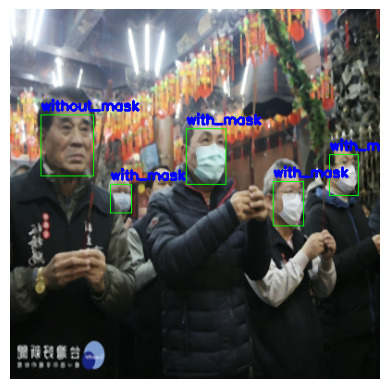

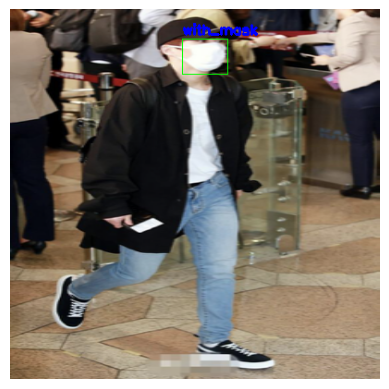

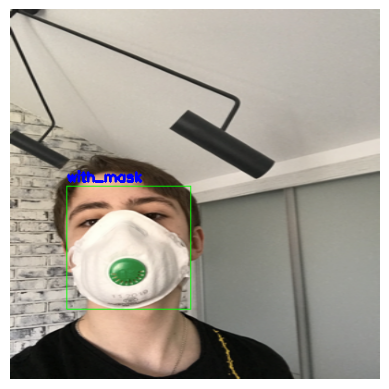

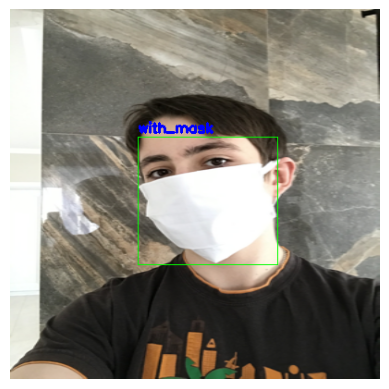

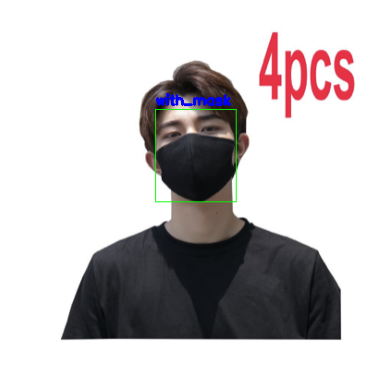

In [ ]:
import matplotlib.pyplot as plt

def visualize_sample(image, target):
    for box, label in zip(target['boxes'], target['labels']):
        label = CLASSES[label]
        cv2.rectangle(
            image,
            (int(box[0]), int(box[1])), (int(box[2]), int(box[3])),
            (0, 255, 0), 1
        )
        cv2.putText(
            image, label, (int(box[0]), int(box[1]-5)),
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2
        )

    plt.imshow(image)
    plt.axis('off')
    plt.show()

for i in random.sample(range(len(train_dataset)), 5):
    image, target = train_dataset[i]
    image = image.numpy()
    image = np.transpose(image, (1, 2, 0))
    visualize_sample(image, target)

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def create_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='DEFAULT')

    in_features = model.roi_heads.box_predictor.cls_score.in_features

    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [ ]:
from tqdm.auto import tqdm

def train(train_dataloader, model, optimizer, train_loss_hist):
    print('Training...')
    global train_itr
    global train_loss_list

    prog_bar = tqdm(train_dataloader, total=len(train_dataloader))

    for i, data in enumerate(prog_bar):
        optimizer.zero_grad()
        images, targets = data

        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        train_loss_list.append(loss_value)
        train_loss_hist.send(loss_value)
        losses.backward()
        optimizer.step()
        train_itr += 1

        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")

    return train_loss_list, train_loss_hist


In [ ]:
def validate(valid_dataloader, model, val_loss_hist):
    print('Validating...')
    global val_itr
    global val_loss_list

    prog_bar = tqdm(valid_dataloader, total=len(valid_dataloader))

    for i, data in enumerate(prog_bar):
        images, targets = data

        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        with torch.no_grad():
            loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        val_loss_list.append(loss_value)
        val_loss_hist.send(loss_value)
        val_itr += 1

        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")

    return val_loss_list, val_loss_hist

In [ ]:
import time

plt.style.use('ggplot')

SAVE_MODEL_EPOCH = 2
NUM_EPOCHS = 20

model = create_model(num_classes=NUM_CLASSES)
model = model.to(DEVICE)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)

train_loss_hist = LossCounter()
valid_loss_hist = LossCounter()

train_itr = 1
val_itr = 1

train_loss_list = []
valid_loss_list = []

MODEL_NAME = 'fasterrcnn_model'

for epoch in range(NUM_EPOCHS):
    print(f'\nEPOCH: {epoch+1} of {NUM_EPOCHS}')

    train_loss_hist.reset()
    valid_loss_hist.reset()

    start = time.time()
    train_loss, train_loss_hist = train(train_loader, model, optimizer, train_loss_hist)
    valid_loss, valid_loss_hist = validate(valid_loader, model, valid_loss_hist)

    print(f"Epoch #{epoch+1} train loss: {train_loss_hist.value:.3f}")
    print(f"Epoch #{epoch+1} validation loss: {valid_loss_hist.value:.3f}")
    end = time.time()
    print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch+1}")

    if (epoch+1) == NUM_EPOCHS: # save model once at the end
        torch.save(model.state_dict(), f"/content/model{epoch+1}.pth")

    elif (epoch+1) % SAVE_MODEL_EPOCH == 0: # save model after every n epochs
        torch.save(model.state_dict(), f"/content/model{epoch+1}.pth")
        print('SAVING MODEL COMPLETE...\n')


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:02<00:00, 78.7MB/s]


KeyboardInterrupt: ignored

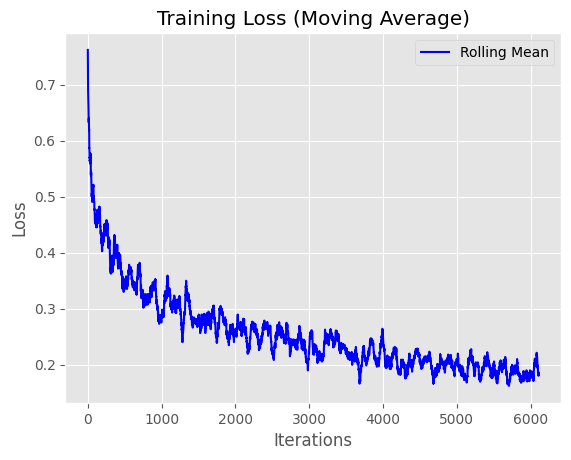

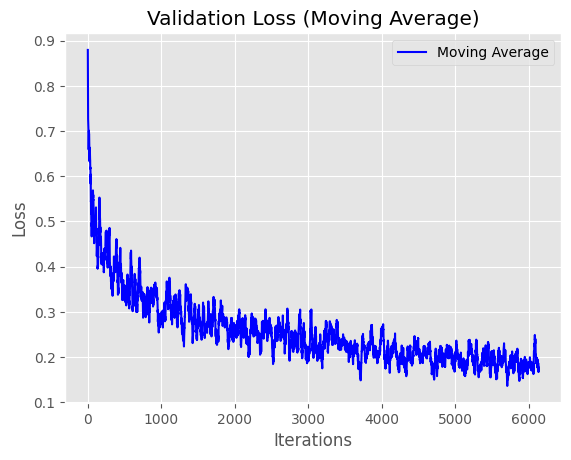

In [ ]:
window_size1 = 50

rolling_mean1 = np.convolve(train_loss, np.ones(window_size1) / window_size1, mode='valid')

plt.plot(rolling_mean1, color='b', label='Rolling Mean')
plt.title("Training Loss (Rolling Mean)")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig("training_loss_plot.png")
plt.show()

window_size2 = 25

rolling_mean2 = np.convolve(train_loss, np.ones(window_size2) / window_size2, mode='valid')

plt.plot(rolling_mean2, color="b", label="Rolling Mean")
plt.title("Validation Loss (Rolling Mean)")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig("validation_loss_plot.png")
plt.show()

Test instances: 128


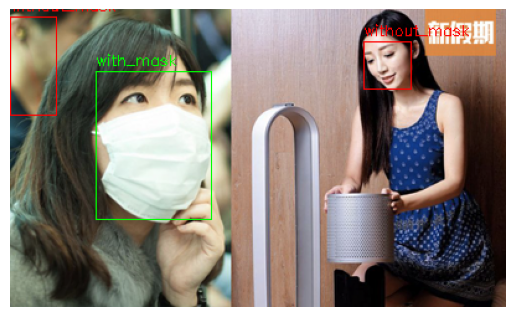

Image 71 done...
--------------------------------------------------


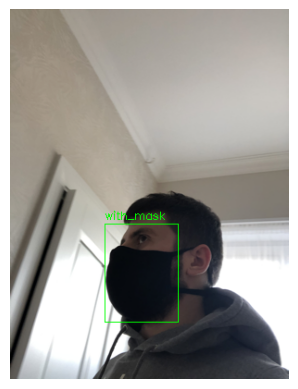

Image 3 done...
--------------------------------------------------


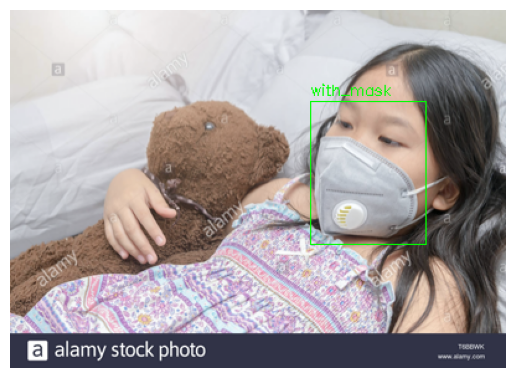

Image 51 done...
--------------------------------------------------


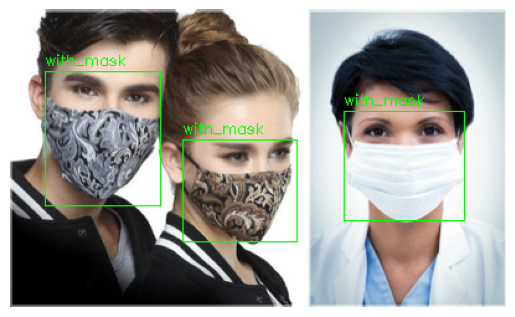

Image 107 done...
--------------------------------------------------


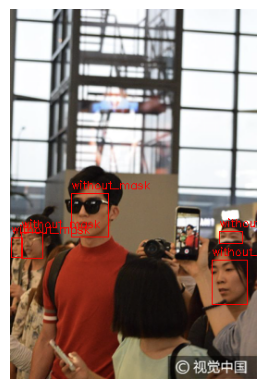

Image 74 done...
--------------------------------------------------
TEST PREDICTIONS COMPLETE


In [ ]:
model = create_model(NUM_CLASSES)
model.load_state_dict(torch.load('/content/drive/MyDrive/model20.pth', map_location=DEVICE))
model.eval()

detection_threshold = 0.5
test_images = []

for i in test_set:
    test_images.append(os.path.join(IMG_DIR, i))

print(f'Test instances: {len(test_images)}')

for i in random.sample(range(len(test_images)), 5):
    image = cv2.imread(test_images[i])
    orig_image = image.copy()
    image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image /= 255.0
    image = np.transpose(image, (2, 0, 1)).astype(float)
    image = torch.tensor(image, dtype=torch.float)#.cuda()
    image = torch.unsqueeze(image, 0)
    with torch.no_grad():
        outputs = model(image)

    outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]

    if len(outputs[0]['boxes']) != 0:
        boxes = outputs[0]['boxes'].data.numpy()
        scores = outputs[0]['scores'].data.numpy()
        labels = outputs[0]['labels'].data.numpy()

        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        labels = labels[scores >= detection_threshold]

        draw_boxes = boxes.copy()

        for box, label in zip(draw_boxes, labels):
            label = CLASSES[label]

            if label == "without_mask":
                color = (0, 0, 255)

            elif label == "with_mask":
                color = (0, 255, 0)

            elif label == "mask_weared_incorrect":
                color = (255, 0, 0)

            cv2.rectangle(orig_image,
                        (int(box[0]), int(box[1])),
                        (int(box[2]), int(box[3])),
                        color, 1)
            cv2.putText(orig_image, label,
                        (int(box[0]), int(box[1])-5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 1)

        image_rgb = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB)
        plt.imshow(image_rgb)
        plt.axis('off')
        plt.show()
    print(f"Image {i+1} done...")
    print('-'*50)
print('TEST PREDICTIONS COMPLETE')

(-0.5, 575.5, 1279.5, -0.5)

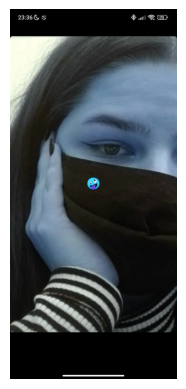

In [ ]:
image = cv2.imread('/content/dasha2.jpg')

plt.imshow(image)
plt.axis('off')

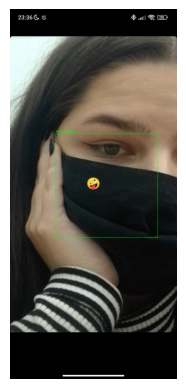

[0.37907913 0.05802011]


In [ ]:
detection_threshold = 0.7

orig_image = image.copy()
image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB).astype(np.float32)
image /= 255.0
image = np.transpose(image, (2, 0, 1)).astype(float)
image = torch.tensor(image, dtype=torch.float)#.cuda()
image = torch.unsqueeze(image, 0)
with torch.no_grad():
    outputs = model(image)

outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]

if len(outputs[0]['boxes']) != 0:
    boxes = outputs[0]['boxes'].data.numpy()
    scores = outputs[0]['scores'].data.numpy()
    labels = outputs[0]['labels'].data.numpy()

    boxes = boxes[scores >= detection_threshold].astype(np.int32)
    labels = labels[scores >= detection_threshold]

    draw_boxes = boxes.copy()

    for box, label in zip(draw_boxes, labels):
        label = CLASSES[label]

        if label == "without_mask":
            color = (0, 0, 255)

        elif label == "with_mask":
            color = (0, 255, 0)

        elif label == "mask_weared_incorrect":
            color = (255, 0, 0)

        cv2.rectangle(orig_image,
                    (int(box[0]), int(box[1])),
                    (int(box[2]), int(box[3])),
                    color, 1)
        cv2.putText(orig_image, label,
                    (int(box[0]), int(box[1])-5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 1)

    image_rgb = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()
    print(scores)
